In [1]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN, RNNSimple
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [2]:
sigma_sq = 0.5

In [3]:
def make_signal_for_prior(time_length, mu_p, sigma_p, uncertainty=0.5, g=1.25):
    input_signals = np.zeros([1, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    
    state = State(mu=mu_p, sigma=sigma_p)
    
    for i in range(1):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state()
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals


def make_sample_signal(g=2):
    input_signals = np.zeros([200, 2, 100])
    phi = np.linspace(-2, 2, 100)
    
    for i, signal_mu in enumerate(np.linspace(-1, 1, 200)):
        signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
        for t in range(2):
            input_signals[i, t] = np.random.poisson(signal_base)
        
    return input_signals

In [4]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random_map/20220526_1/20220526_1.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random_map/{model_name}/epoch_500.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220526_1


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [5]:
mu_p_list = np.linspace(-0.5, 0.5, 11)
sigma_p_list = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [6]:
sigma_l = math.sqrt(1/1.25) * 0.5
mu_p_list = []
sigma_p_list = []

neural_states = np.zeros((300, 200*30))
reservoir_states = np.zeros((300, 50*30))
for i in range(300):
    mu_p = np.random.rand()-0.5
    sigma_p = np.random.rand()*0.8
    mu_p_list.append(mu_p)
    sigma_p_list.append(sigma_p)
    input_signal = make_signal_for_prior(
        time_length=50, 
        mu_p=mu_p,
        sigma_p=sigma_p,
        uncertainty=0.5,
        g=1.25,
    )
    inputs = torch.from_numpy(input_signal).float()                                 
    inputs = inputs.to(device) 
    hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
    reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
         
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device) 
    reservoir = torch.from_numpy(reservoir_np).float()
    reservoir = reservoir.to(device)
    hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 50) 
        
    neural_dynamics = hidden_list.cpu().detach().numpy()   
    reservoir_dynamics = reservoir_list.cpu().detach().numpy()
        
    neural_states[i] = neural_dynamics[0, -30:].reshape(30*200)
    reservoir_states[i] = reservoir_dynamics[0, -30:].reshape(30*50)

In [7]:
neural_states_all = neural_states.reshape(300, 200*30)
reservoir_states_all = reservoir_states.reshape(300, 50*30)

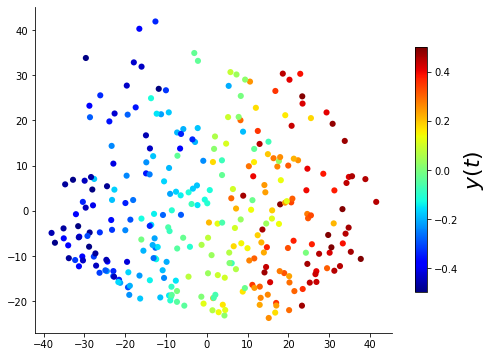

In [8]:
pca = PCA(n_components=3)
pca.fit(neural_states_all)

trajectory = pca.transform(neural_states_all)

fig = plt.figure(figsize=(8, 6))

internal_dynamics = plt.scatter(
    trajectory[:, 0], 
    trajectory[:, 1],  
    c=mu_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$y(t)$', fontsize=22)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

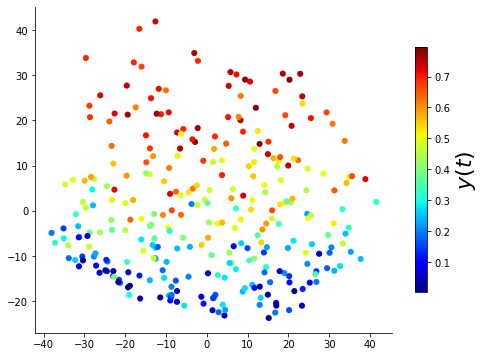

In [9]:
pca = PCA(n_components=3)
pca.fit(neural_states_all)

trajectory = pca.transform(neural_states_all)

fig = plt.figure(figsize=(8, 6))

internal_dynamics = plt.scatter(
    trajectory[:, 0], 
    trajectory[:, 1],  
    c=sigma_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$y(t)$', fontsize=22)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')